<h1><center>NEURAL CONTROL OF MOVEMENT</center></h1>

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
from numpy.linalg import inv

<h2><center>Plotting Functions</center></h2>

In [3]:
def plot_two_by_four(data, ylabel, title = None):
    fig, axs = plt.subplots(2, 4, figsize = (16,7), sharex = 'all', sharey = 'all')
    for i in range(2):
        for j in range(4):
            axs[i][j].plot(t_dynamics, data[:, :, 4 * i + j].T, linewidth = 1.5)
            axs[i][j].tick_params(axis='both', which='major', labelsize=12)
            axs[i][j].tick_params(axis='both', which='minor', labelsize=12)
            if i == 1:
                axs[i][j].set_xlabel('Time/s', fontsize = 12)
            if j == 0:
                axs[i][j].set_ylabel(ylabel, fontsize = 12)
    fig.suptitle(title, fontsize = 24)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_movement(torques):
    mvt_angles = np.empty((2, N_dynamics, NUM_REACHES))

    fig, ax = plt.subplots(figsize = (10,10))

    for i in range(NUM_REACHES):
        angles = solve_arm_model(THETA_INIT, DTHETA_INIT, dt, N_dynamics, B_arm_model, torques[:,:,i])
        mvt_angles[:,:,i] = angles
        theta_1 = angles[0,:]
        theta_2 = angles[1,:]
        trajectories = np.array([L_1*np.cos(theta_1)+L_2*np.cos(theta_1+theta_2), L_1*np.sin(theta_1) + L_2*np.sin(theta_1+theta_2)])
        ax.plot(trajectories[0], trajectories[1], linewidth = 4)

    ax.set_xlabel(r'$x_1$', fontsize = 24)
    ax.set_ylabel(r'$x_2$', fontsize = 24)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    plt.show()

<h2><center>Global Variables</center></h2>

In [5]:
NUM_REACHES = 8
NUM_NEURONS = 200

###### EULER SOLVER #####
dt = 0.0005
t_dynamics = np.arange(0, 1, dt)
N_dynamics = len(t_dynamics)

###### M1 DYNAMICS ######
TAU = 0.15
TAU_RISE = 0.5
TAU_DECAY = 0.05

h_t_MAX = 5
h_t_MAX_TIME = (np.log(TAU_RISE/TAU_DECAY))/((1/TAU_DECAY)-(1/TAU_RISE))
SCALING_FACTOR = h_t_MAX/(np.exp(-h_t_MAX_TIME/TAU_DECAY)-np.exp(-h_t_MAX_TIME/TAU_RISE))  #h_t is an alpha shaped input bump with the scaling factor set such that it has a maximum value of 5

###### ARM MECHANICS AND HAND TRAJECTORIES ######
THETA_INIT = np.array([10*np.pi/180, 143.54*np.pi/180])
DTHETA_INIT = np.array([0, 0])
L_1 = 0.3
L_2 = 0.33
I_1 = 0.025
I_2 = 0.045
M_1 = 1.4
M_2 = 1.0
D_2 = 0.16

a_1 = I_1 + I_2 + M_2 * (L_1**2)
a_2 = M_2 * L_1 * D_2
a_3 = I_2

B_arm_model = np.array([[0.05, 0.025], [0.025, 0.05]])

##### Full Circuit Model ######
LAMBDA = 0.1

These are the initial inputs to the arm model and their respective shapes\
We have the synaptic connectivity matrix `W` - **(200 * 200)**\
Spontaneous firing rate for each of the 200 neurons - **(200)**\
`H_BAR` is the input held constant throughout all phases of the task - **(200)**\
`x_stars` is the set of 8 initial conditions that result in the correct movement - **(200 * 8)**\
`C` is the mapping from firing rates to arm torques - **(2 * 200)**

In [6]:
# Load all the model parameter files

model_folder = 'Network Model Files/'
W = pd.read_csv(model_folder + 'W_matrix.txt', header = None, delimiter = '\t').dropna(axis=1,how='all').values
spontaneous_firing_rates = np.reshape(pd.read_csv(model_folder + 'spontaneous_firing.txt', header = None, delimiter = '\t').dropna(axis=1, how='all').values, 200)
H_BAR = np.reshape(spontaneous_firing_rates - W @ np.maximum(spontaneous_firing_rates, 0), 200)
x_stars = pd.read_csv(model_folder + 'x_stars.txt', header = None, delimiter = '\t').dropna(axis=1, how='all').values + np.reshape(spontaneous_firing_rates, (200, 1))

C_movement = np.zeros((2, NUM_NEURONS))
C_movement[:, :160] = pd.read_csv(model_folder + 'C_matrix.txt', header = None, delimiter = '\t').dropna(axis=1, how='all').values

<h2><center>Movement Execution<center></h2>

The dynamics of the network are given by the following non-linear differential equation:

<center>$\tau\frac{d\boldsymbol{x}}{dt} = -\boldsymbol{x}(t) + \boldsymbol{W}\phi[\boldsymbol{x}(t)] + \overline{\boldsymbol{h}} + h(t) + \boldsymbol{u}(t)$</center>

$\tau$ is the single neuron time constant, $\boldsymbol{x}$ is the vector of activations, $\boldsymbol{W}$ is the synaptic connectivity matrix, $\phi[.]$ is a ReLU nonlinearity, $\overline{\boldsymbol{h}}$ is the constant input, $h(t)$ is a transient, condition independent $\alpha$-shaped input bump and $\boldsymbol{u}(t)$ is a preparatory control input used to drive the circuit into the correct preparatory states

We can simulate the behaviour of the network for a given set of initial conditions by using the Euler Method. We see that after some initial transience the activations converge to some steady state.

In [7]:
def M1_dynamics(x, t, u, K, execution, linearised, standard_form):
    if execution:
        h_t = SCALING_FACTOR * (np.exp(-(t/TAU_DECAY)) - np.exp(-(t/TAU_RISE)))
        dxdt = (-x + W @ (np.maximum(x, 0)) + H_BAR + h_t)/TAU
    elif linearised:
        dxdt = (-x + W @ x + H_BAR + u + K @ x )/TAU
    elif standard_form:
        dxdt = A @ x + B @ u + H_BAR
    else:
        dxdt = (-x + W @ (np.maximum(x, 0)) + H_BAR + u + K @ (np.maximum(x, 0)))/TAU
    return dxdt

def solve_M1_dynamics(x0, dt, num_steps, t, u = None, K = None, execution = True, linearised = False, standard_form = False):
    x = np.zeros((NUM_NEURONS, num_steps))
    x[:, 0] = x0
    
    # Discrete Euler solver
    for step in range(num_steps - 1):
        x[:, step + 1] = x[:, step] + M1_dynamics(x[:, step], t[step], u, K, execution, linearised, standard_form) * dt
    return x

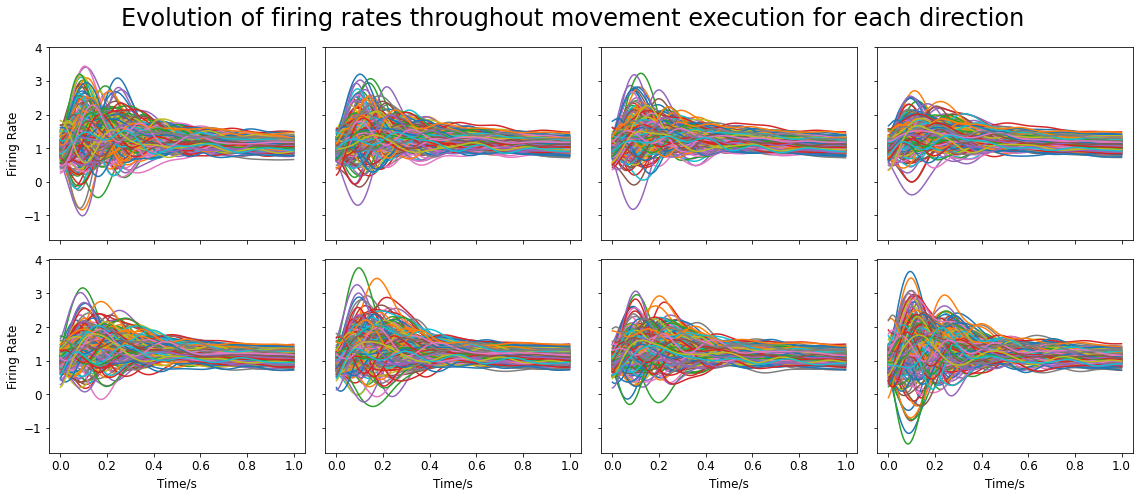

In [8]:
firing_rate_stars = np.empty((NUM_NEURONS, N_dynamics, NUM_REACHES))

# For each of the 8 movements, simulate the dynamics of neural activity
for i in range(NUM_REACHES):
    firing_rate_stars[:,:,i] = solve_M1_dynamics(x_stars[:,i], dt, N_dynamics, t_dynamics, H_BAR, SCALING_FACTOR, execution = True)
    
plot_two_by_four(firing_rate_stars, "Firing Rate", "Evolution of firing rates throughout movement execution for each direction")

We map these to torques using the matrix C, which represents the BMI. Note that only the excitatory neurons contribute to the torques. $\phi()$ is the non-linearity as before.

<center>$\boldsymbol{m}(t) = \boldsymbol{C}\phi[\boldsymbol{x}_E(t)]$</center>

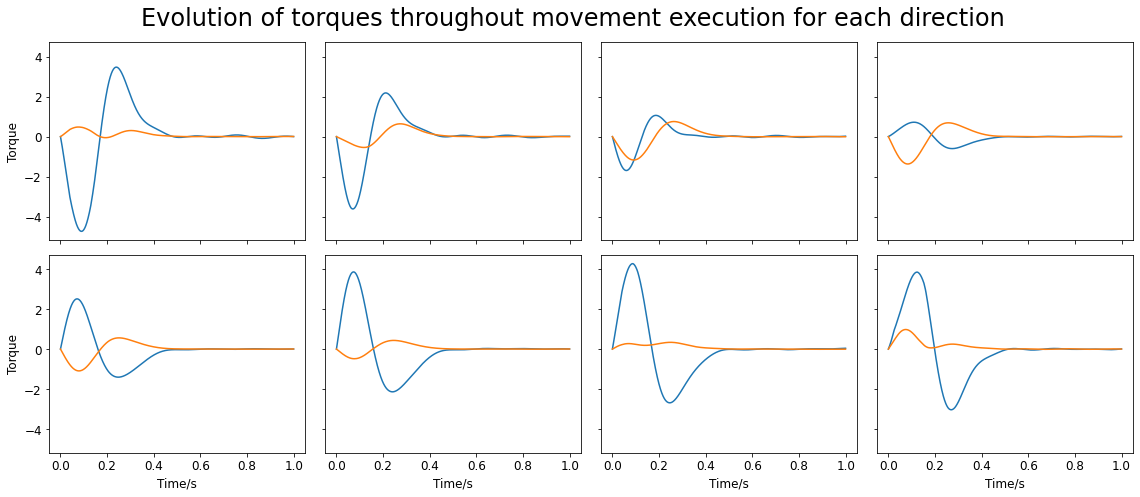

In [9]:
torque_stars = np.empty([2, N_dynamics, NUM_REACHES])

# For each set of neural activity, calculate the corresponding torque output
for i in range(NUM_REACHES):
    torque_stars[:,:,i]  = C_movement @ np.maximum(firing_rate_stars[:, :, i], 0)
    
plot_two_by_four(torque_stars, 'Torque', 'Evolution of torques throughout movement execution for each direction')

The joint angles $\boldsymbol{\theta}$ of the arm model evolve according to the following second order differential equation:

<center>$\boldsymbol{m}(t) = \mathcal{M}(\boldsymbol{\theta})\boldsymbol{\ddot{\theta}} + \mathcal{C}(\boldsymbol{\theta,\dot{\theta} })+\mathcal{B}\boldsymbol{\dot\theta}$</center>

$\boldsymbol{m}(t)$ is the momentary torque vector, $\mathcal{M}$ is the matrix of inertia, $\mathcal{C}$ accounts for centripetal and coriolis forces and $\mathcal{B}$ is a dampening matrix representing joint friction. We can solve this numerically by first converting to system of first order ODEs and then using the Euler Method as before.

In [28]:
def M_func(phi):
    M = np.array([[a_1 + 2.*a_2 * np.cos(phi[1]), a_3 + a_2*np.cos(phi[1])],[a_3 + a_2*np.cos(phi[1]), a_3]])
    return np.linalg.inv(M)
    
def C_func(phi, phi_dot):
    C = a_2 * np.sin(phi[1]) * np.array([-phi_dot[1] * (2.*phi_dot[0] + phi_dot[1]), phi_dot[0]**2])     
    return C
    

def arm_model(phi_1, phi_2, B, torque, M_func, C_func):

    dphi_2 = M_func(phi_1) @ (torque - C_func(phi_1, phi_2) - (B @ phi_2))
    
    return dphi_2

def solve_arm_model(theta_init, theta_dot_init, dt, num_steps, B, torque):
    
    phi_1 = np.zeros((2, num_steps))
    phi_2 = np.zeros((2, num_steps))

    phi_1[:, 0] = theta_init
    phi_2[:, 0] = theta_dot_init
    
    for step in range(num_steps-1):
        
        phi_1[:, step + 1] = phi_1[:, step] + phi_2[:, step] * dt
        phi_2[:, step + 1] = phi_2[:, step] + arm_model(phi_1[:, step], phi_2[:, step], B, torque[:, step]) * dt

    return phi_1

Finally, the hand trajectories are given by:

<center>$\boldsymbol{y} = \left( \begin{array}{c}
L_1 cos(\theta_1) + L_2(cos(\theta_1 + \theta_2)\\
L_1 sin(\theta_1) + L_2(sin(\theta_1 + \theta_2) \end{array} \right)$</center>

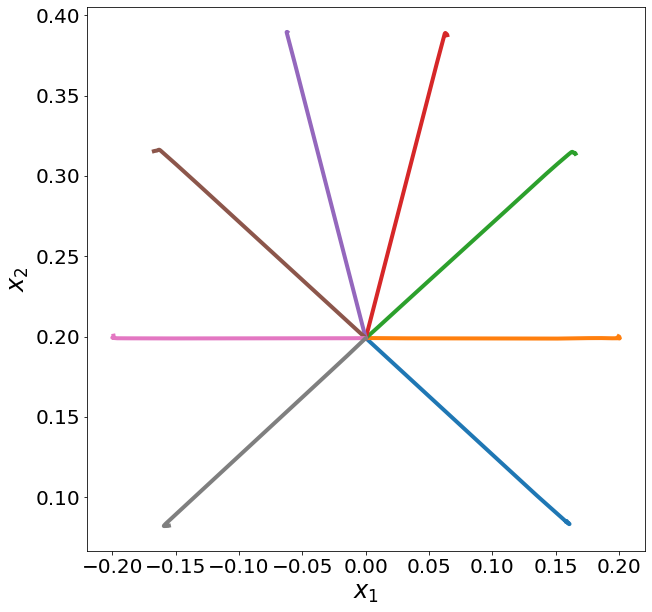

In [11]:
plot_movement(torque_stars)

 <h2><center>Movement Preparation</center></h2>

Now that we have a functioning model of movement execution, we need to add movement preparation. The role of the preparatory activity is to move the neural activity from some spontaneous activity to the "optimal subspace", at which point the control input is withdrawn and the movement is initiated. \
The preparatory control input $\boldsymbol{u}$ acts as a feedback loop, forcing the activity towards the optimal subspace. It is defined as:

\begin{equation}
    \boldsymbol{u}(t) = \tilde{\boldsymbol{u}} + \boldsymbol{K}\phi[\boldsymbol{x}(t)]
\end{equation}

$\tilde{\boldsymbol{u}}$ is some movement-specific constant input, and $\boldsymbol{K}\phi[\boldsymbol{x}(t)]$ is the optimal feedback controller. $\boldsymbol{K}$ is defined as $\lambda^{-1}\boldsymbol{P}$ where $\boldsymbol{P}$ is the solution to the Riccati Equation:

\begin{equation}
    \boldsymbol{A}^T\boldsymbol{P}+\boldsymbol{P}\boldsymbol{A}-\lambda^{-1}\boldsymbol{P}\boldsymbol{P}+\boldsymbol{Q} = 0
\end{equation}

where $\boldsymbol{A}$ is the effective state transition matrix $\boldsymbol{W} - \boldsymbol{I}$ and $\boldsymbol{Q}$ is the observability Gramian, found by solving the Lyapunov Equation:

\begin{equation}
    \boldsymbol{A}^T\boldsymbol{Q}+\boldsymbol{Q}\boldsymbol{A}+ \tau\boldsymbol{C}^T\boldsymbol{C} = 0
\end{equation}

In [14]:
I = np.identity(NUM_NEURONS)
W_BAR = W - I

#Solve Lyapunov Equation to find the observability gramian Q
Q_obsv= sp.linalg.solve_continuous_lyapunov(W_BAR.T, -1*(TAU * C_movement.T @ C_movement))


#Solve the Algebraic Riccati Equation (ARE)
K = -(LAMBDA**-1) * sp.linalg.solve_continuous_are(W_BAR, I, Q_obsv, (LAMBDA**-1)*I)

We calculate $\boldsymbol{\tilde{u}}$ by requiring $\boldsymbol{x}$ to reach initial condition $\boldsymbol{x^*}$, so the control input must eventually settle at a steady-state value given by:

\begin{align*}
    0 & = -\boldsymbol{x^*} + \boldsymbol{W}\phi(\boldsymbol{x^*})  + \tilde{\boldsymbol{u}} + \boldsymbol{K}\phi(\boldsymbol{x^*}) + \overline{\boldsymbol{h}}\\
    \tilde{\boldsymbol{u}} & = \boldsymbol{x^*} - (\boldsymbol{W}+\boldsymbol{K})\phi(\boldsymbol{x^*})-\overline{\boldsymbol{h}}
\end{align*}

Each direction of movement will give a separate constant $\boldsymbol{\tilde{u}}$ vector. These can be stacked into a matrix $\boldsymbol{\tilde{U}}$, where each column represents the steady state input for one direction

In [15]:
#Calculate columns of U that will map to correct initial conditions (optimal subspace)
U_tilde = np.empty((NUM_NEURONS, NUM_REACHES))

for i in range(NUM_REACHES):
    U_tilde[:,i] =  x_stars[:,i] - (W + K) @ np.maximum(x_stars[:,i],0) - H_BAR

We can now initialise the neurons at some spontaneous firing rate, and use $\boldsymbol{\tilde{U}}$ and $K$ to drive the activity to the optimal subspace. Once converged, we can initiate the movement and we should observe the same straight reaches as before.

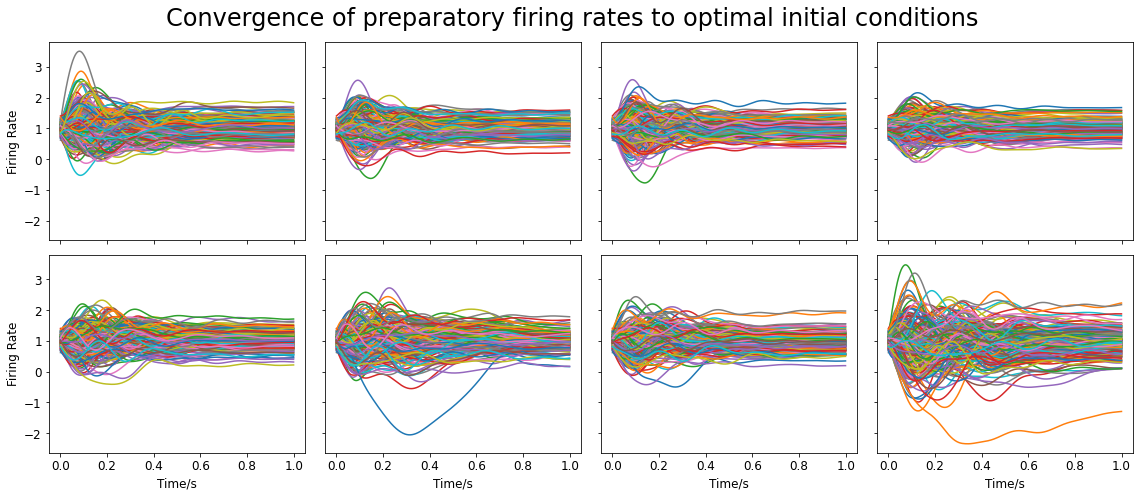

In [16]:
t_prep = np.arange(0, 1, dt)
N_prep = len(t_prep)
all_prep_firing_rates = np.empty((NUM_NEURONS, N_prep, NUM_REACHES))
test_x_stars = np.empty((NUM_NEURONS, NUM_REACHES))

for i in range(NUM_REACHES):
    prep_firing_rates = solve_M1_dynamics(spontaneous_firing_rates, dt, N_prep, t_prep, U_tilde[:,i], K, execution = False)
    test_x_stars[:,i] = prep_firing_rates[:, -1]
    all_prep_firing_rates[:,:,i] = prep_firing_rates

plot_two_by_four(all_prep_firing_rates, 'Firing Rate', 'Convergence of preparatory firing rates to optimal initial conditions')

In [17]:
test_torque_stars = np.empty([2, N_dynamics, NUM_REACHES])

for i in range(NUM_REACHES):
    test_firing_rates = solve_M1_dynamics(test_x_stars[:,i], dt, N_dynamics, t_dynamics, execution = True)
    test_torque_stars[:,:,i] = C_movement @ np.maximum(test_firing_rates, 0)

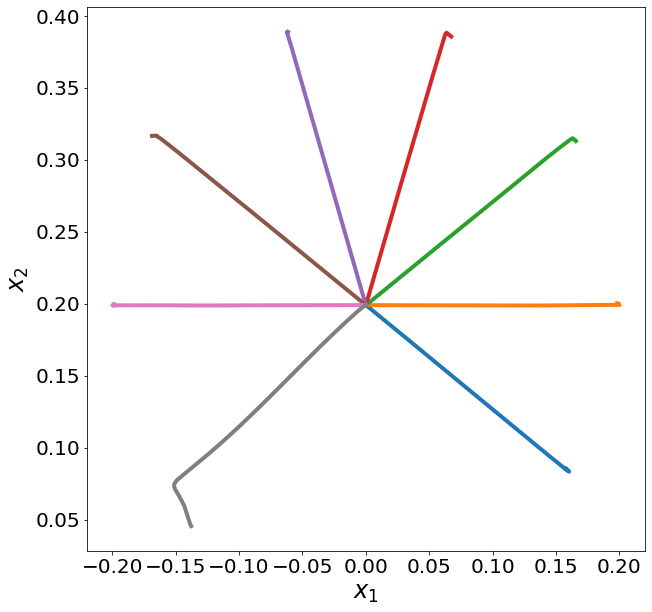

In [18]:
plot_movement(test_torque_stars)

<h2><center>Finding the Intrinsic Manifold</center></h2>

Now that we have a functioning model of movement preparation, we wish to define the intrinsic manifold. First, n order to simplify notation, we will linearise the differential equation and then convert it to standard state-space form. Removing the non-linearity gives:

\begin{equation}
    \boldsymbol{\dot{x}} = (\boldsymbol{W}-\boldsymbol{I}+\boldsymbol{K})\boldsymbol{x} + \boldsymbol{\tilde{U}}\boldsymbol{z} + \boldsymbol{\bar{h}}
\end{equation}

Then let $\boldsymbol{A} := (\boldsymbol{W}-\boldsymbol{I}+\boldsymbol{K})$, $\boldsymbol{B}:=\boldsymbol{\tilde{U}}$ and $\boldsymbol{z} := \boldsymbol{u}$ This gives:

\begin{equation}
    \boldsymbol{\dot{x}} = \boldsymbol{A}\boldsymbol{x} + \boldsymbol{B}\boldsymbol{u} + \boldsymbol{\bar{h}}
\end{equation}

In [19]:
########  CHANGE OF NOTATION TO CONVERT IT TO STANDARD FORM  ########
A = (W - I + K)/TAU
B = U_tilde/TAU

There are now two ways of finding the intrinsic manifold. The first is to drive the dynamics using white noise, $dW$, making it a stochastic differential equation:

\begin{equation}
    \boldsymbol{\dot{x}} = \boldsymbol{A}\boldsymbol{x} + \boldsymbol{B}dW + \overline{\boldsymbol{h}}
\end{equation}

The noise enters M1, and reverberates due to the effect of the $\boldsymbol{A}$ matrix. The system will eventually reach a some statistical steady state, with $\boldsymbol{x}$ fluctuating, driven by the noise. The dynamics means there is short-term memory, so the fluctuations in $\boldsymbol{x}$ will no longer be white in time, but will have some temporal correlation length (although it will still look noisy). We can then find the covariance matrix, where the $ij^{th}$ element tells us the covariance between the fluctuations in neuron $j$ and neuron $i$. 


In [20]:
t_stoch = np.arange(0,10,dt)
N_stoch = len(t_stoch)

def white(seed):
    
    np.random.seed(seed)                                                                
    samples = np.sqrt(2/TAU)*np.random.normal(0., 1., int(N_stoch))/np.sqrt(dt)
    return samples

white_noise = np.empty((8, N_stoch))
for i in range(8):
    white_noise[i, :] = white(i)

def SDE(x, index, A, B, dW):

    dxdt = A @ x + B @ dW[:, index] + H_BAR
    
    return dxdt

def solve_stochastic(x0, dt, num_steps, t, A, B, white_noise):
    x = np.zeros((NUM_NEURONS, num_steps))
    x[:,0] = x0

    for step in range(num_steps-1):
        x[:, step+1] = x[:, step] + SDE(x[:, step], step, A, B, white_noise)*dt
    return x

SDE_solution = solve_stochastic(spontaneous_firing_rates, dt, N_stoch, t_stoch, A, U_tilde, white_noise)

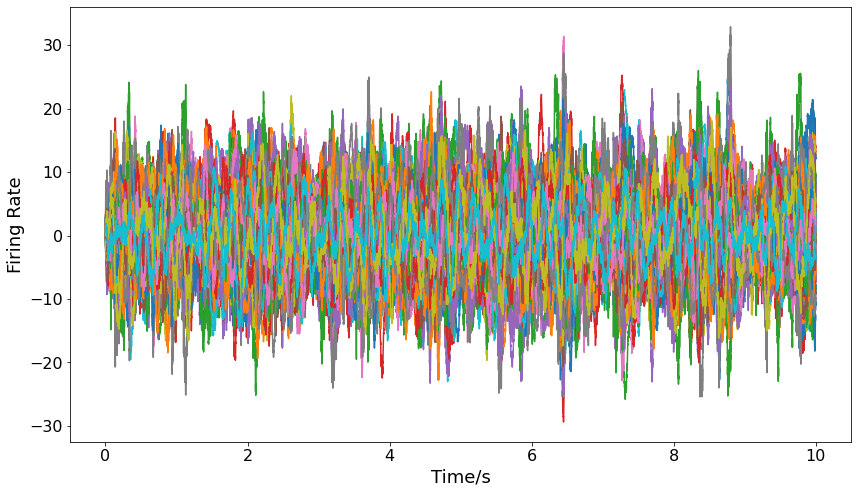

In [21]:
fig, ax = plt.subplots(figsize = (14,8))

ax.plot(t_stoch, SDE_solution.T)
ax.set_xlabel('Time/s', fontsize = 18)
ax.set_ylabel('Firing Rate', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

We find the intrinsic manifold by performing PCA on the covariance matrix. We find the eigenvalues and eigenvectors of $\boldsymbol{P}$, the covariance matrix, where the meaning of each eigenvalue is the amount of variance that is captured in the corresponding eigenvector. Denote the orthonormal matrix of eigenvectors as $\boldsymbol{S}$, where the first column corresponds to the maximum eigenvalue. 

In [22]:
#Find eigenvectors from covariance of SDE
P = np.cov(SDE_solution)
(eig_val_P, eig_vec_P) = np.linalg.eig(P)

It can be shown that the covariance matrix also obeys the following Lyapunov equation:

\begin{equation}
    \boldsymbol{A}\boldsymbol{P}+\boldsymbol{P}\boldsymbol{A}^T+ \boldsymbol{B}\boldsymbol{B}^T = 0
    \label{controllability}
\end{equation}

We can solve this for $\boldsymbol{P}$ and then perform PCA just as before.

In [23]:
#Define Intrinsic Manifold using Lyapunov Equation
COVARIANCE = sp.linalg.solve_continuous_lyapunov(A, -2*TAU*B@B.T)
u_A, s_A, u_T_A = sp.linalg.svd(COVARIANCE)

We can now plot the eigenvalues in decreasing order. The eigenvalues of the SDE covariance matrix will tend towards the eigenvalues of the Lyapunov solution as $t$ tends to $\infty$

/Users/DanielJackson1/MachineLearning/ML_env/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


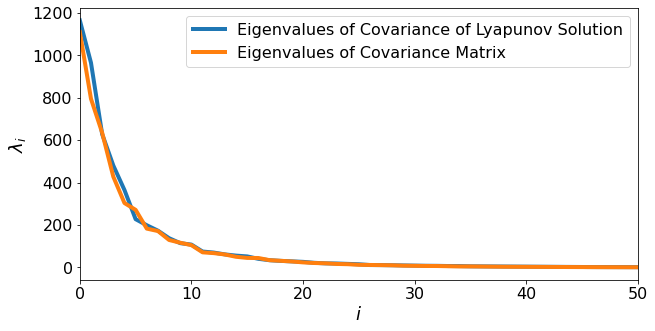

In [24]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(s_A, label = 'Eigenvalues of Covariance of Lyapunov Solution', linewidth = 4)
ax.plot(eig_val_P, label = 'Eigenvalues of Covariance Matrix', linewidth = 4)
ax.set_xlabel(r'$i$', fontsize = 18)
ax.set_ylabel(r'$\lambda_i$', fontsize = 18)
ax.set_xlim(0, 50)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.legend(fontsize = 16)
plt.show()

Denote the orthonormal matrix of eigenvectors as $\boldsymbol{S}$
We can quantify the amount of variance accounted for by each consecutive column of $\boldsymbol{S}$:

\begin{equation}
    V = trace(\boldsymbol{S}_{0...i}\boldsymbol{P}\boldsymbol{S}_{0...i}^T)
\end{equation}

where $\boldsymbol{S}_{0...i}$ represents the first $i$ columns of $\boldsymbol{S}$ and $\boldsymbol{P}$ is the covariance matrix of the spontaneous activity. As $i$ increases, more of the total variance of $\boldsymbol{S}$ is accounted for, although more and more slowly, as the variance accounted for by each consecutive eigenvector decreases (as the corresponding eigenvalue decreases)

We choose to define the Intrinsic Manifold as the columns of $\boldsymbol{S}$ that account for 95% of the variance

In [25]:
ORTH_BASIS = u_A
total_variance = np.trace(COVARIANCE)
var = 0
column = 0
while var < 0.95:
    column += 1
    var = np.trace(ORTH_BASIS[:, :column].T@ COVARIANCE @ ORTH_BASIS[:, :column])/total_variance
print(column)   

20


This means that the first 20 columns of the orthonormal basis of the covariance account for 95% of the variance. Thus the intrinsic manifold is defined as the matrix consisting of those 20 eigenvectors.

In [26]:
##### THIS IS THE INTRINSIC MANIFOLD ######
INTRINSIC_MANIFOLD = ORTH_BASIS[:,:column]
print(np.shape(INTRINSIC_MANIFOLD))

(200, 20)


<h2><center>Save Data files</center></h2>

In [27]:
folder = 'Numpy Data Files/'
np.save(folder + 'H_BAR.npy', H_BAR)
np.save(folder + 'A.npy', A)
np.save(folder + 'B.npy', B)
np.save(folder + 'COVARIANCE.npy', COVARIANCE)
np.save(folder + 'ORTH_BASIS.npy', ORTH_BASIS)
np.save(folder + 'INTRINSIC_MANIFOLD.npy', INTRINSIC_MANIFOLD)
np.save(folder + 'spontaneous_activity.npy', spontaneous_firing_rates)